In [52]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import ortho_group

## Set up matplotlib plotting parameters

In [42]:
def init_plotting():
  plt.rcParams['figure.figsize'] = (8, 5.5)
  plt.rcParams['pdf.fonttype'] = 42
  plt.rcParams['font.size'] = 18
  plt.rcParams['axes.labelsize'] = 1.2 * plt.rcParams['font.size']
  plt.rcParams['axes.titlesize'] = 1.5 * plt.rcParams['font.size']
  plt.rcParams['legend.fontsize'] = 1.2 * plt.rcParams['font.size']
  plt.rcParams['xtick.labelsize'] = 1.2 * plt.rcParams['font.size']
  plt.rcParams['ytick.labelsize'] = 1.2 * plt.rcParams['font.size']
  plt.rcParams["legend.framealpha"] = 0.7
  plt.rcParams['lines.linewidth'] = 2.5
  plt.rcParams['lines.markersize'] = 10

init_plotting()

### Implementation of different algorithms

In [53]:
def GDA(H, z_init, eta, steps=10000):
  traj = np.zeros((steps, z_init.shape[0]))
  traj[0, :] = z_init[:, 0]
  z = z_init.copy()
  for i in range(1, steps):
    z = z - eta * H @ z
    traj[i, :] = z[:, 0]
  return traj

def alt_GDA(H, z_init, eta, steps=10000):
  dim = z_init.shape[0] // 2
  traj = np.zeros((steps, z_init.shape[0]))
  traj[0, :] = z_init[:, 0]
  z = z_init.copy()
  for i in range(1, steps):
    z[:dim] = z[:dim] - eta * H[:dim, :] @ z
    z[dim:] = z[dim:] - eta * H[dim:, :] @ z
    traj[i, :] = z[:, 0]
  return traj

def OGDA(H, z_init, eta, steps=10000):
  traj = np.zeros((steps, z_init.shape[0]))
  traj[0, :] = z_init[:, 0]
  z = z_init.copy()
  z_old = z_init.copy()
  z_new = z_init.copy()
  for i in range(1, steps):
    z = z - eta * H @ (2 * z - z_old)
    z_old = z_new.copy()
    z_new = z.copy()
    traj[i, :] = z[:, 0]
  return traj

def EG(H, z_init, eta, steps=10000):
  traj = np.zeros((steps, z_init.shape[0]))
  traj[0, :] = z_init[:, 0]
  z = z_init.copy()
  for i in range(1, steps):
    z_mid = z - eta * H @ z
    z = z - eta * H @ z_mid
    traj[i, :] = z[:, 0]
  return traj

def NM(H, z_init, eta, beta, steps=10000):
  dim = z_init.shape[0] // 2
  traj = np.zeros((steps, z_init.shape[0]))
  traj[0, :] = z_init[:, 0]
  z = z_init.copy()
  z_old = z_init.copy()
  z_new = z_init.copy()
  for i in range(1, steps):
    z = (1 + beta) * z - beta * z_old - eta * H @ z
    z_old = z_new.copy()
    z_new = z.copy()
    traj[i, :] = z[:, 0]
  return traj

## Sample matrices for quadratic minimax games

In [54]:
h = 1.0 / np.linspace(1, 100, num=10)
h = np.repeat(h, 10)
Q1 = ortho_group.rvs(dim=100)
A = Q1 @ np.diag(h) @ Q1.T
Q2 = ortho_group.rvs(dim=100)
C = Q2 @ np.diag(h) @ Q2.T

B = np.random.randn(100, 100) * 0.1
H = np.block([[A, B], [-B.T, C]])
e, v = np.linalg.eig(H)

### Compute the condition number

In [55]:
k = np.max(np.abs(e)) / np.min(e.real)
print(k)

51.415914866152015


## Plotting

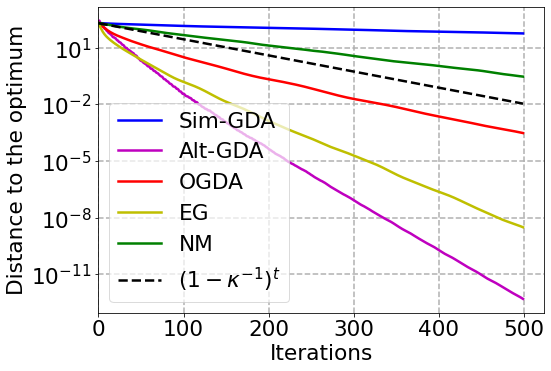

In [57]:
z_init = np.ones((200, 1))
iterations = 500
gda_traj = GDA(H, z_init, 0.03, steps=iterations)
gda_dist = np.sum(gda_traj ** 2, axis=1)
agda_traj = alt_GDA(H, z_init, 0.8, steps=iterations)
agda_dist = np.sum(agda_traj ** 2, axis=1)

ogda_traj = OGDA(H, z_init, 0.25, steps=iterations)
ogda_dist = np.sum(ogda_traj ** 2, axis=1)
eg_traj = EG(H, z_init, 0.5, steps=iterations)
eg_dist = np.sum(eg_traj ** 2, axis=1)
nm_traj = NM(H, z_init, 0.25, -0.9, steps=iterations)
nm_dist = np.sum(nm_traj ** 2, axis=1)

plt.plot(range(iterations), gda_dist, color='b', label='Sim-GDA')
plt.plot(range(iterations), agda_dist, color='m', label='Alt-GDA')
plt.plot(range(iterations), ogda_dist, color='r', label='OGDA')
plt.plot(range(iterations), eg_dist, color='y', label='EG')
plt.plot(range(iterations), nm_dist, color='g', label='NM')
plt.plot(range(iterations), agda_dist[0] * (1 - (1/k)) ** np.linspace(1, iterations, num=iterations), color='k', linestyle='--', label=r'$(1 - \kappa^{-1})^t$')
plt.xlim(xmin=0)
plt.yscale('log')
plt.legend()
plt.grid(linestyle='--', linewidth=1.5)
plt.xlabel('Iterations')
plt.ylabel('Distance to the optimum')
plt.tight_layout()

## Plotting the iteration complexity as a function of condition number

In [70]:
mus = np.logspace(-0.5, -3, num=6)

B = np.random.randn(100, 100)
e, _ = np.linalg.eig(B.T @ B)
B = B / np.max(e ** 0.5)
Q1 = ortho_group.rvs(dim=100)
Q2 = ortho_group.rvs(dim=100)

best_e1_list = []
best_e2_list = []
best_e3_list = []
best_e4_list = []
best_e5_list = []
kappa_list = []
for mu in mus:
  h = 1.0 / np.linspace(1, 1/mu, num=100)
  
  A = Q1 @ np.diag(h) @ Q1.T
  C = Q2 @ np.diag(h) @ Q2.T

  H = np.block([[A, B], [-B.T, C]])
  e, v = np.linalg.eig(H)
  kappa = np.max(np.abs(e)) / np.min(e.real)
  kappa_list.append(kappa)
  L = np.max(np.abs(e))

  iden = np.eye(200)
  best_e1 = best_e2 = best_e3 = best_e4 = best_e5 = 1.0
  for eta in np.logspace(math.log10(1/(4*kappa * L)), math.log10(4/(kappa * L)), num=20):
    # Sim-GDA
    J1 = iden - eta * H
    e1, _ = np.linalg.eig(J1)
    if np.max(np.abs(e1)) < best_e1:
      best_e1 = np.max(np.abs(e1))

  for eta in np.logspace(math.log10(1/(4 * L)), math.log10(4/(L)), num=20):
    # EG
    J3 = iden - eta * H @ (iden - eta * H)
    e3, _ = np.linalg.eig(J3)
    if np.max(np.abs(e3)) < best_e3:
      best_e3 = np.max(np.abs(e3))

  for eta in np.logspace(math.log10(1/(4 * L)), math.log10(4/(L)), num=20):
    # OGDA
    J4 = np.block([[iden - 2 * eta * H, eta * H], [iden, np.zeros_like(iden)]])
    e4, _ = np.linalg.eig(J4)
    if np.max(np.abs(e4)) < best_e4:
      best_e4 = np.max(np.abs(e4))

  for eta in np.logspace(math.log10(1/(4 * L)), math.log10(4/(L)), num=20):
    # Alt-GDA
    J5 = np.block([[np.eye(100) - eta*A - eta**2*B@B.T, -eta*B + eta**2*B@C], [eta*B.T, np.eye(100) - eta*C]])
    e5, _ = np.linalg.eig(J5)
    if np.max(np.abs(e5)) < best_e5:
      best_e5 = np.max(np.abs(e5))

  for eta in np.logspace(math.log10(1/(4 * L * kappa ** 0.5)), math.log10(4/(L * kappa ** 0.5)), num=20):
    # NM
    for beta in np.logspace(-math.log10(kappa), 0, num=11):
      J2 = np.block([[beta*iden - eta*H, (1-beta)*iden], [iden, np.zeros_like(iden)]])
      e2, _ = np.linalg.eig(J2)
      if np.max(np.abs(e2)) < best_e2:
        best_e2 = np.max(np.abs(e2))
  best_e1_list.append(-1.0 / math.log(best_e1))
  best_e2_list.append(-1.0 / math.log(best_e2))
  best_e3_list.append(-1.0 / math.log(best_e3))
  best_e4_list.append(-1.0 / math.log(best_e4))
  best_e5_list.append(-1.0 / math.log(best_e5))

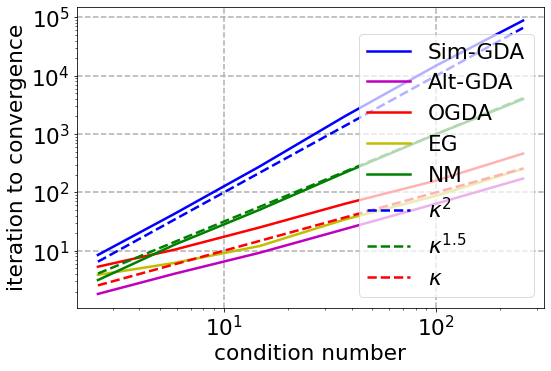

In [71]:
reference = [kappa ** 1.5 for kappa in kappa_list]
reference2 = [kappa ** 2 for kappa in kappa_list]
plt.plot(kappa_list, best_e1_list, color='b', label='Sim-GDA')
plt.plot(kappa_list, best_e5_list, color='m', label='Alt-GDA')
plt.plot(kappa_list, best_e4_list, color='r', label='OGDA')
plt.plot(kappa_list, best_e3_list, color='y', label='EG')
plt.plot(kappa_list, best_e2_list, color='g', label='NM')

plt.plot(kappa_list, reference2, color='b', linestyle='--', label='$\kappa^2$')
plt.plot(kappa_list, reference, color='g', linestyle='--', label='$\kappa^{1.5}$')
plt.plot(kappa_list, kappa_list, color='r', linestyle='--', label='$\kappa$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(linestyle='--', linewidth=1.5)
plt.xlabel('condition number')
plt.ylabel('iteration to convergence')
plt.tight_layout()